In [1]:
# Cell 1 — imports + load cleaned CSV
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

ROOT = Path("../data/processed")
clean_path = ROOT / "aspirin_clean.csv"   # adjust if different
df = pd.read_csv(clean_path)
df.shape, list(df.columns)[:40]


((351, 8),
 ['safetyreportid',
  'receivedate',
  'sex',
  'age',
  'age_unit',
  'seriousnessdeath',
  'seriousnesshospitalization',
  'reaction'])

In [2]:
# Cell 2 — shape, dtypes, missingness, duplicates
print("rows:", df.shape[0])
print("columns:", df.shape[1])
display(df.dtypes)

# missing values
missing = df.isna().mean().sort_values(ascending=False)
display(missing[missing > 0].head(30))

# check duplicates by safetyreportid+reaction
dups = df.duplicated(subset=["safetyreportid","reaction"]).sum()
print("duplicate report+reaction rows:", dups)


rows: 351
columns: 8


safetyreportid                  int64
receivedate                     int64
sex                           float64
age                           float64
age_unit                      float64
seriousnessdeath              float64
seriousnesshospitalization    float64
reaction                       object
dtype: object

seriousnessdeath              0.908832
seriousnesshospitalization    0.629630
age                           0.153846
age_unit                      0.153846
sex                           0.011396
dtype: float64

duplicate report+reaction rows: 3


reaction
Rash                        9
Drug interaction            8
Dizziness                   7
Type 2 diabetes mellitus    7
Fatigue                     7
Name: count, dtype: int64


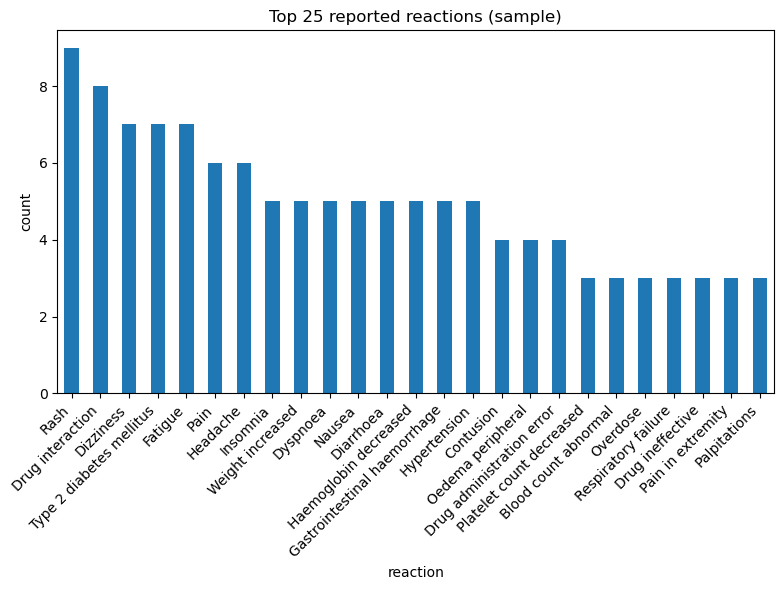

In [3]:
# Cell 3 — top reactions (bar)
topN = 25
top = df["reaction"].value_counts().head(topN)
print(top.head())

# plot
plt.figure(figsize=(8,6))
top.plot.bar()
plt.title(f"Top {topN} reported reactions (sample)")
plt.ylabel("count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("../data/processed/top_reactions.png")
plt.show()


In [4]:
# Cell 4 — create per-report seriousness label
# If your columns are 1/0 or strings, normalize to ints
for col in ["seriousnessdeath","seriousnesshospitalization","seriousnesslifethreatening","seriousnessdisabling","seriousnesscongenitalanomali","seriousnessother"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

# Per-row is_serious
df["is_serious"] = (df[[c for c in df.columns if c.startswith("seriousness")]].sum(axis=1) > 0).astype(int)

# seriousness rate
ser_rate = df["is_serious"].mean()
print(f"Overall seriousness rate (reaction-level rows): {ser_rate:.3f}")


Overall seriousness rate (reaction-level rows): 0.422


/var/folders/0l/6vyd7t0s5n36rmvwf6jq4jw00000gn/T/ipykernel_2861/175663532.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = df.set_index("receivedate").resample("M").agg(total_reports=("safetyreportid","nunique"),
/opt/anaconda3/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/opt/anaconda3/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


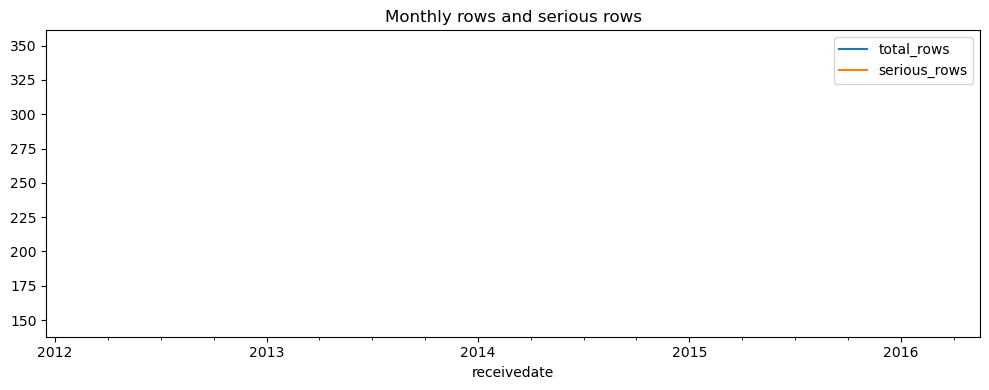

/opt/anaconda3/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


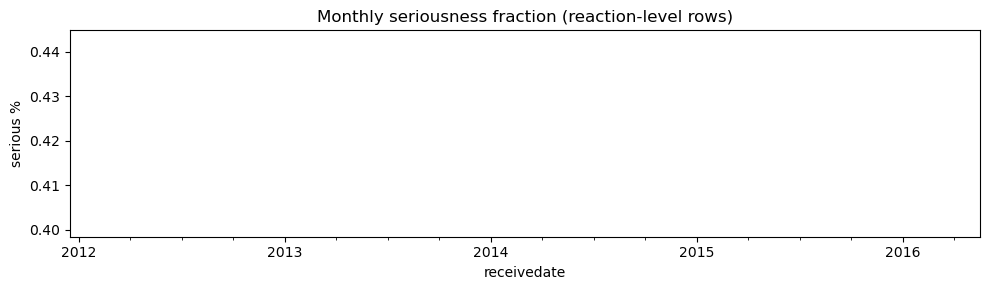

In [5]:
# Cell 5 — time series
df["receivedate"] = pd.to_datetime(df["receivedate"], format="%Y%m%d", errors="coerce")
ts = df.set_index("receivedate").resample("M").agg(total_reports=("safetyreportid","nunique"),
                                                    total_rows=("reaction","count"),
                                                    serious_rows=("is_serious","sum"))
ts["serious_pct"] = ts["serious_rows"] / ts["total_rows"]
ts[["total_rows","serious_rows"]].plot(figsize=(10,4))
plt.title("Monthly rows and serious rows")
plt.tight_layout()
plt.savefig("../data/processed/monthly_counts.png")
plt.show()

plt.figure(figsize=(10,3))
ts["serious_pct"].plot()
plt.title("Monthly seriousness fraction (reaction-level rows)")
plt.ylabel("serious %")
plt.tight_layout()
plt.savefig("../data/processed/monthly_serious_pct.png")
plt.show()


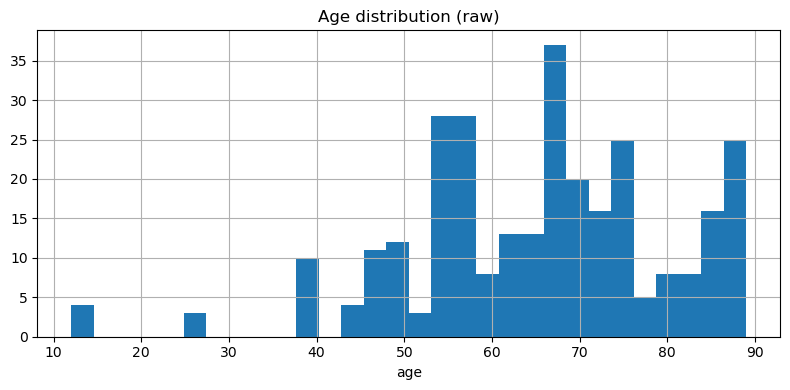

,mean,count
sex_label,,
Male,0.469072,194
Female,0.368421,152
Unknown,0.200000,5


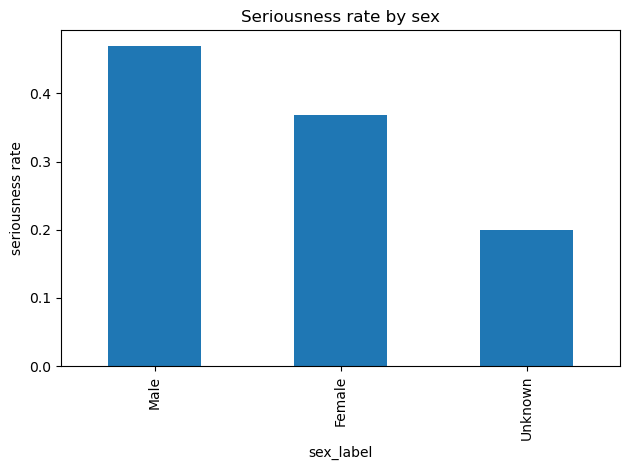

In [6]:
# Cell 6 — age distribution and seriousness by sex
# clean age numeric
df["age"] = pd.to_numeric(df["age"], errors="coerce")

# age histogram
plt.figure(figsize=(8,4))
df["age"].dropna().hist(bins=30)
plt.title("Age distribution (raw)")
plt.xlabel("age")
plt.tight_layout()
plt.savefig("../data/processed/age_hist.png")
plt.show()

# seriousness by sex (group)
if "sex" in df.columns:
    # map codes if necessary (1 male, 2 female sometimes)
    df["sex_label"] = df["sex"].map({1:"Male", 2:"Female"}).fillna("Unknown")
    grp = df.groupby("sex_label")["is_serious"].agg(["mean","count"]).sort_values("count", ascending=False)
    display(grp)
    # bar
    grp["mean"].plot.bar()
    plt.title("Seriousness rate by sex")
    plt.ylabel("seriousness rate")
    plt.tight_layout()
    plt.savefig("../data/processed/serious_by_sex.png")
    plt.show()


In [7]:
# attach drug counts & top-drug flags
report_agg["drug_list"] = (
    report_agg["safetyreportid"]
    .map(report_drugs)
    .apply(lambda x: x if isinstance(x, list) else [])
)

report_agg["n_drugs"] = report_agg["drug_list"].apply(len)

# build boolean flag for top drugs (example: aspirin present)
report_agg["aspirin_present"] = report_agg["drug_list"].apply(
    lambda L: any("aspirin" in s for s in L)
)


NameError: name 'report_agg' is not defined

In [83]:
# filter only top reactions
tmp = df[df["reaction"].isin(top_reacts)].copy()
tmp["flag"] = 1

# pivot into wide one-hot form
pivot = tmp.pivot_table(
    index="safetyreportid", 
    columns="reaction", 
    values="flag", 
    aggfunc="max",  # 1 if reaction present
    fill_value=0
).astype(int)

# merge back into report_agg
for col in pivot.columns:
    colname = f"react_{col[:40]}"  # safe short names
    report_agg[colname] = report_agg["safetyreportid"].map(pivot[col].to_dict()).fillna(0).astype(int)

report_agg.shape


(100, 41)

,total,serious,serious_rate
reaction,,,
Rash,9,2,0.222222
Drug interaction,8,8,1.000000
Dizziness,7,3,0.428571
Type 2 diabetes mellitus,7,2,0.285714
Fatigue,7,3,0.428571
Pain,6,2,0.333333
Headache,6,0,0.000000
Insomnia,5,1,0.200000
Weight increased,5,0,0.000000


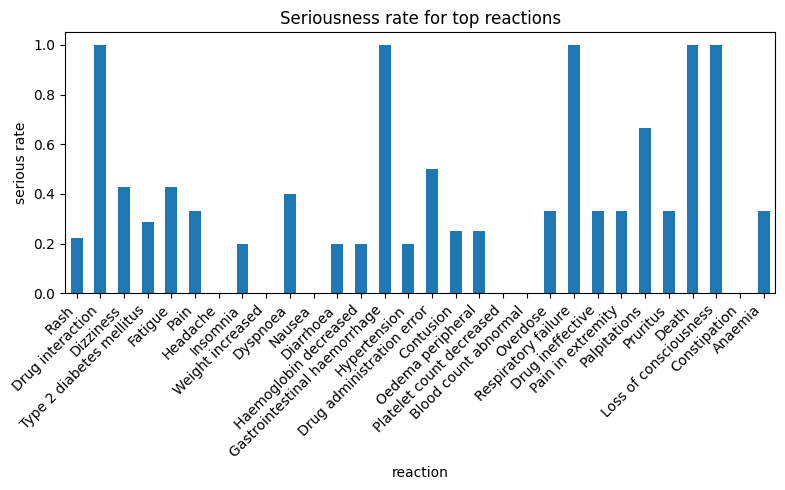

,mean,count
aspirin_present,,
False,0.36,100


In [84]:
# Cell 9 — seriousness rate by reaction (top 20)
rx = df.groupby("reaction").agg(total=("reaction","count"), serious=("is_serious","sum"))
rx["serious_rate"] = rx["serious"] / rx["total"]
rx = rx.loc[top_reacts].sort_values("total", ascending=False)
display(rx.head(20))

# plot top reactions serious rate
plt.figure(figsize=(8,5))
rx["serious_rate"].plot.bar()
plt.title("Seriousness rate for top reactions")
plt.ylabel("serious rate")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("../data/processed/reaction_serious_rate.png")
plt.show()

# seriousness by top drugs (report level)
drug_ser = report_agg.groupby("aspirin_present")["is_serious_report"].agg(["mean","count"])
display(drug_ser)


In [85]:
# Cell 11 — save features for modeling
out_features = ROOT / "report_features.csv"
# choose subset of usable columns
cols_to_keep = ["safetyreportid","receivedate","sex","age_mean","age_bin","n_reactions","n_drugs","aspirin_present","is_serious_report"] + [c for c in report_agg.columns if c.startswith("react_")]
report_agg[cols_to_keep].to_csv(out_features, index=False)
print("Saved features to", out_features)


Saved features to ../data/processed/report_features.csv
